In [1]:
import os
import sys
import numpy as np
import pandas as pd
import glob
# import pickle
# import collections
import matplotlib.pyplot as plt
# import torch
# import time
# import hashlib
# import PIL
import shutil

sys.path.insert(0, os.path.join("..", "..", ".."))

from petroflow import Well, WellBatch, WS, WellDataset
# from petroflow.batchflow.models.metrics import SegmentationMetricsByPixels
from petroflow.batchflow.models.torch import UNet, ResNet18, ResNet34
from petroflow.batchflow import Dataset, FilesIndex, Pipeline, V, B, inbatch_parallel, I, W, F, L

In [2]:
# well = Well('/notebooks/data/september_dataset/core_photo/Зимнее/3_зимнее',pixels_per_cm=25, resize=False)
# well.has_attr('grain')
# well.create_segments('samples', connected=False)
# plt.figure(figsize=(15, 10))
# plt.imshow(well.iter_level()[4].core_dl / 255)
# import copy
# well2 = copy.deepcopy(well)
# well2.create_segments('grain', length=0.1)
# s = well2.iter_level()[3]
# plt.imshow(s.core_dl / 255)

In [3]:
# s.core_dl.shape

In [4]:
index = FilesIndex(path='/notebooks/data/september_dataset/core_photo/*/*', dirs=True)

class MyWellBatch(WellBatch):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, pixels_per_cm=25, resize=False, **kwargs)

ds = Dataset(index=index, batch_class=MyWellBatch)
# ds.split(0.8, shuffle=42)

In [5]:
filter_ppl = (ds.p
              .init_variable('wells', default=[])
              .has_attr('grain')
              .update(V('wells', mode='e'), B().indices)
              .run(10, n_epochs=1, shuffle=False, bar=True))

100%|██████████| 21/21 [00:00<00:00, 68.64it/s]


In [6]:
filtered_index = index.create_subset(filter_ppl.v('wells'))
ds = Dataset(index=filtered_index, batch_class=MyWellBatch)
ds.split()

In [7]:
classes = ['GRAVEL', 'SAND', 'ALEURITE', 'CLAY']

weights = pd.read_feather('/notebooks/data/september_dataset/grain.feather')[classes].mean() / 100
weights = 1 / weights
weights = np.clip(weights, 0, 60)

In [8]:
weights

GRAVEL      60.000000
SAND         1.754773
ALEURITE     3.581530
CLAY         6.893672
dtype: float64

In [9]:
BATCH_SIZE = 16
N_EPOCH = 500
LENGTH = 0.1
SHAPE = (6, int(2500 * LENGTH), 250)

import torch
from torch import nn
import torch.nn.functional as F

class softCrossEntropy(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = weights
        return

    def forward(self, inputs, target):
        """
        :param inputs: predictions
        :param target: target labels
        :return: loss
        """
        log_likelihood = - F.log_softmax(inputs, dim=1)
        log_likelihood *= self.weights
        sample_num, class_num = target.shape
        loss = torch.sum(torch.mul(log_likelihood, target)) / sample_num

        return loss

model_config = {'initial_block/inputs': 'images',
                'inputs/images/shape': SHAPE,
                'inputs/labels/classes': 4,
                'optimizer': ('SGD', dict(lr=0.01, momentum=0.95)),
                'device': 'gpu:1',
                'output': 'proba',
                'loss': (softCrossEntropy, {'weights': torch.tensor(weights).to('cuda:1')})}

split_template = (Pipeline()
   .create_segments(src='samples', connected=True)
   .create_segments(src='grain', length=LENGTH)
   .sample_segments(n_segments=4)
)

random_indices = L(np.random.choice)(
    L(len)(B()),
    L(min)(
        L(len)(B()), 32
    ), replace=False
)

reg_template = (Pipeline()
    .add_namespace(np)
    .drop_short_segments(LENGTH)
    .update(B('crops_dl'), WS('core_dl').ravel())
    .update(B('crops_uv'), WS('core_uv').ravel())
    .update(B('targets'), WS('grain')[classes].iloc[0].values.ravel())
    .array(B('targets'), save_to=B('targets'))
    .concatenate((B('crops_dl'), B('crops_uv')), axis=-1, save_to=B('crops'))
    .transpose(B('crops'), axes=(0, 3, 1, 2), save_to=B('crops'))
    .nan_to_num(B('crops'), save_to=B('crops'))
    .array(B('crops'), dtype='float32', save_to=B('crops'))
    .array(B('targets'), dtype='float32', save_to=B('targets'))
)

def mydump(iteration):
    import pickle
    with open('flag', 'wb') as f:
        pickle.dump(iteration, f)

train_template = (Pipeline()
    .init_variable('loss_history', default=[])
    .init_model('dynamic', ResNet18, 'model', model_config)
    .mydump(I())
    .train_model('model', B('crops'), B('targets') / 100, fetches='loss', save_to=V('loss_history', mode='a'))
    
)

In [10]:
ppl = (split_template) << ds.train

In [11]:
b = ppl.next_batch(1)

In [37]:
# pd.read_feather('/notebooks/data/september_dataset/core_photo/Восточно-Мессояхское/123_восточно-мессояхское/grain.feather')

In [12]:
ppl.run(BATCH_SIZE, n_epochs=N_EPOCH, bar=True, shuffle=True,
        drop_last=True, bar_desc=W(V('loss_history')[-1]))

4.6499543:   0%|          | 1/4000 [00:04<5:31:24,  4.97s/it]/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

3.562818:  44%|████▍     | 1756/4000 [2:17:38<3:13:48,  5.18s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

3.0468757: 100%|██████████| 4000/4000 [5:13:37<00:00,  4.63s/it]  


In [13]:
import pickle
ppl.get_model_by_name('model').save('model.torch')

with open('loss', 'wb') as f:
    pickle.dump(ppl.get_variable('loss_history'), f)

with open('dataset', 'wb') as f:
    pickle.dump(ds, f)

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:256: UserWarning:

Couldn't retrieve source code for container of type softCrossEntropy. It won't be checked for correctness upon loading.



In [18]:
with open('loss', 'rb') as f:
    loss = pickle.load(f)

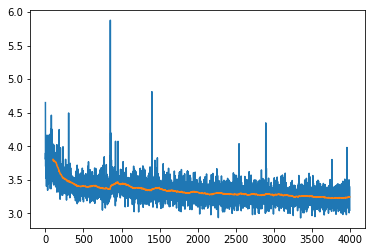

In [20]:
import pandas as pd
plt.plot(loss)
plt.plot(pd.Series(np.array(loss)).rolling(100).mean())

In [26]:
split_test = (Pipeline()
    .create_segments(src='samples', connected=True)
    .create_segments(src='grain', length=LENGTH)
)

test_template = (Pipeline()
    .init_variable('lithology', default=[])
    .update(V('lithology', mode='e'), WS('grain').iloc[0].ravel())
    .init_variable('predictions', default=[])
    .init_model('dynamic', ResNet18, 'model', config={
                    'device': 'cpu', 'load/path': 'model.torch'
                })
    .predict_model('model', B('crops'), fetches='proba', save_to=V('predictions', mode='e')) 
)

In [27]:
ppl = (split_test + reg_template + test_template) << ds.test
ppl.run(1, n_epochs=1, bar=True)





  0%|          | 0/32 [00:00<?, ?it/s]



  3%|▎         | 1/32 [00:01<00:44,  1.43s/it]



  6%|▋         | 2/32 [00:02<00:44,  1.47s/it]



  9%|▉         | 3/32 [00:04<00:44,  1.55s/it]



 12%|█▎        | 4/32 [00:05<00:35,  1.28s/it]



 16%|█▌        | 5/32 [00:05<00:27,  1.00s/it]



 19%|█▉        | 6/32 [00:06<00:26,  1.00s/it]



 22%|██▏       | 7/32 [00:07<00:26,  1.05s/it]



 25%|██▌       | 8/32 [00:08<00:20,  1.17it/s]



 28%|██▊       | 9/32 [00:10<00:30,  1.33s/it]



 31%|███▏      | 10/32 [00:11<00:26,  1.20s/it]



 34%|███▍      | 11/32 [00:13<00:26,  1.26s/it]



 38%|███▊      | 12/32 [00:18<00:50,  2.53s/it]



 41%|████      | 13/32 [00:20<00:43,  2.31s/it]



 44%|████▍     | 14/32 [00:21<00:33,  1.84s/it]



 47%|████▋     | 15/32 [00:22<00:31,  1.86s/it]



 50%|█████     | 16/32 [00:23<00:24,  1.52s/it]



 53%|█████▎    | 17/32 [00:24<00:18,  1.25s/it]



 56%|█████▋    | 18/32 [00:25<00:17,  1.27s/it]



 59%|█████▉    | 19/32 [00:27<00:17,  1.38s/i

In [28]:
target = pd.concat(ppl.v('lithology'), axis=1).transpose()

In [29]:
values = np.array(ppl.v('predictions')) * 100
pred = pd.DataFrame({
    'GRAVEL_PRED': values[:, 0],
    'SAND_PRED': values[:, 1],
    'ALEURITE_PRED': values[:, 2],
    'CLAY_PRED': values[:, 3]
})

In [30]:
results = pd.concat([target.reset_index(), pred], axis=1)

In [31]:
results

,index,FIELD,WELL,GRAVEL,SAND,ALEURITE,CLAY,LITHOLOGY,ALEURITE_PRED,CLAY_PRED,GRAVEL_PRED,SAND_PRED
0,2471.55,Воргенское,777_воргенское,0,16.0677,59.9668,23.9655,алевролит глинистый песчанистый слабо извес...,29.512205,48.298927,0.005801,22.183060
1,2475.00,Воргенское,777_воргенское,0,13.8873,63.0146,23.0981,алевролит глинистый песчанистый слабо извес...,31.425322,36.930824,0.026966,31.616894
2,2479.38,Воргенское,777_воргенское,0,9.24147,62.1964,28.5622,алевролит сильно глинистый известковистый с...,33.120125,39.637028,0.008232,27.234617
3,2481.69,Воргенское,777_воргенское,0,15.1958,58.971,25.8332,алевролит сильно глинистый песчанистый слаб...,29.560226,51.164257,0.006578,19.268940
4,2485.61,Воргенское,777_воргенское,0,8.94218,65.2038,25.854,алевролит сильно глинистый слабо песчанистый...,33.238293,33.174561,0.061217,33.525925
5,2538.93,Воргенское,777_воргенское,0,7.84507,53.3575,38.7975,алевролит сильно глинистый слабо песчанистый...,30.675129,40.243511,0.024117,29.057253
6,2539.91,Воргенское,777_воргенское,0,13.1294,52.6087,34.2619,алевролит сильно глинистый песчанистый изве...,29.543718,41.181210,0.018907,29.256168
7,2555.94,Воргенское,777_воргенское,0,51.9393,36.6559,11.4048,песчаник алевролитовый глинистый,24.969755,27.764219,0.049503,47.216530
8,2558.27,Воргенское,777_воргенское,0,80.7469,14.0775,5.17566,песчаник известковистый алевролитистый слаб...,20.189077,25.896772,0.030012,53.884136
9,2655.41,Воргенское,777_воргенское,0,75.2921,17.7948,6.91317,песчаник алевролитистый слабо глинистый,13.902049,29.984671,0.030860,56.082420


In [32]:
results['LITHOLOGY'] = results.LITHOLOGY.apply(lambda x: x.split(' ')[0].capitalize())

In [33]:
classes = ['Песчаник', 'Алевролит', 'Глина']
colors = ['r', 'g', 'b', 'y']

mask = [np.isin(item, classes) for item in results.LITHOLOGY]

In [34]:
# grain.columns[3:7]
from sklearn.manifold import TSNE
tsne_res = TSNE(n_components=2, n_iter_without_progress=500).fit_transform(results[
    ['GRAVEL_PRED', 'SAND_PRED', 'ALEURITE_PRED', 'CLAY_PRED']
])

([], <a list of 0 Text yticklabel objects>)

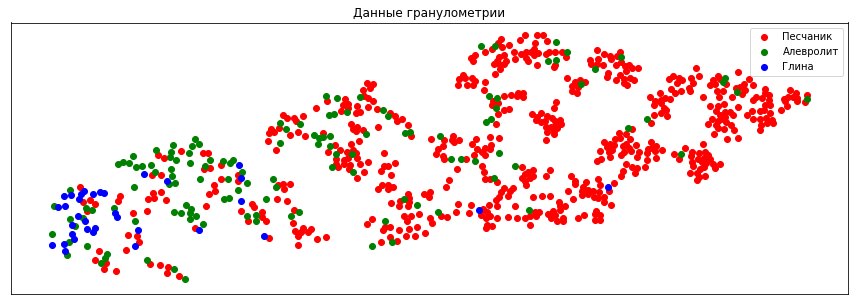

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

for label, color in zip(classes, colors):
    plt.scatter(tsne_res[(results.LITHOLOGY == label).values, 0],
                tsne_res[(results.LITHOLOGY == label).values, 1], color=color, label=label)

plt.title('Данные гранулометрии')
plt.legend()
plt.xticks([])
plt.yticks([])